In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
import seaborn as sns

In [2]:
outpath = "output/visium_meta/"

In [15]:

dataname = "V1_Mouse_Brain_Sagittal_Posterior"
cer_loc_name = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/spatial/tissue_positions_list.csv".format(dataname)
im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/{}_image.tif".format(dataname,dataname)
filt_bc_name = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/filtered_feature_bc_matrix/barcodes.tsv.gz".format(dataname)

Image.MAX_IMAGE_PIXELS = 692696316
bound = 5
rank_quant = "_r_0.01"

# blur over spot
blurval = 70
q = 10

  
# load in tissue positions list and image

cer_loc = pd.read_csv(cer_loc_name,names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
filt_bc = pd.read_csv(filt_bc_name,names=["barcode"])

# subset to only spots in the tissue (by spaceranger)
cer_loc = cer_loc[cer_loc["barcode"].isin(set(filt_bc["barcode"]))]

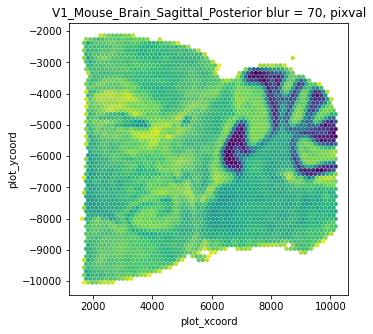

In [16]:
cer_loc["cell_id"] = dataname + "_" + cer_loc["barcode"].str.split("_").str[0].str[:-2]

# get coordinates that make image line up when plotted
cer_loc["plot_xcoord"] = cer_loc["ycoord"]
cer_loc["plot_ycoord"] = -cer_loc["xcoord"]

# load image, convert to grayscale, and blur
img = Image.open(im_path)
img = img.convert('L')
img = img.filter(ImageFilter.GaussianBlur(radius=blurval))
blur = np.array(img)

# get pixel values from the image
cer_loc["pixval"] = -1
for index, row in cer_loc.iterrows():
  cer_loc.loc[index,"pixval"] = blur[row["xcoord"],row["ycoord"]]

# plot raw pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixval",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixval".format(dataname,blurval))
plt.savefig("{}{}_pixval.png".format(outpath,dataname))
plt.show()



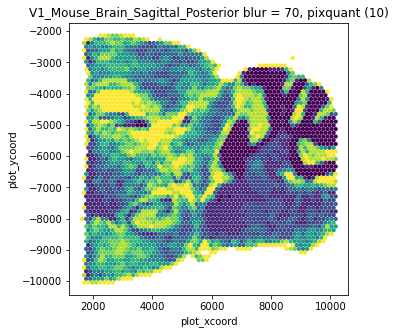

In [17]:
# quantile pixvals
temp = cer_loc.drop_duplicates("barcode")[["barcode","pixval"]]

# decrease the number of quantiles if necessary (all of the same value don't fit in a bin)
qval = q
while True:
  try:
    temp["pixquant"] = pd.qcut(temp['pixval'], qval, labels=False)
    break
  except:
    qval -= 1
    print(qval)
temp.index = temp["barcode"]
cer_loc["pixquant"] = cer_loc["barcode"].map(temp["pixquant"])

# plot quantiled pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixquant",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixquant ({})".format(dataname,blurval,q))
plt.savefig("{}{}_pixquant.png".format(outpath,dataname))

plt.show()
img.save("{}{}_blur.png".format(outpath,dataname))
img.show()

In [18]:

# save new file
cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname),sep="\t",index=False)
print("{}meta_{}.tsv".format(outpath,dataname))

output/visium_meta/meta_V1_Mouse_Brain_Sagittal_Posterior.tsv
